<a href="https://colab.research.google.com/github/simecek/dspracticum2020/blob/master/lecture_02/02_dense_neural_network_and_MPG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


## Data

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()

# because of missing values in the Horsepower column
dataset = dataset.dropna()

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [3]:
# one-hot encoding
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [4]:
# split the dataset into two parts (train & test)
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.shape, test_dataset.shape

((314, 10), (78, 10))

In [5]:
# separate label column from the data
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((314, 9), (78, 9), (314,), (78,))

## Predict MPG (miles per gallon) from Horsepower using DNN

In [7]:
# normalizer
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

In [9]:
# model definition
dnn_horsepower_model = keras.Sequential([
      horsepower_normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
])

dnn_horsepower_model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

In [10]:
dnn_horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [11]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 18ms/step - loss: 23.2804 - val_loss: 21.8829
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 23.0700 - val_loss: 21.6547
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 22.8292 - val_loss: 21.3737
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 22.5191 - val_loss: 21.0031
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 22.1125 - val_loss: 20.5059
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 21.5746 - val_loss: 19.8592
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 20.8610 - val_loss: 19.0304
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 19.9639 - val_loss: 17.9566
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 18.8351 - val_loss: 16.7881
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 17.5850 - val_loss: 15.5340
Epoch 11

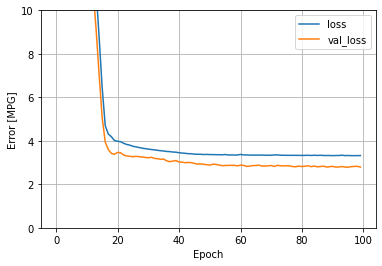

In [12]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

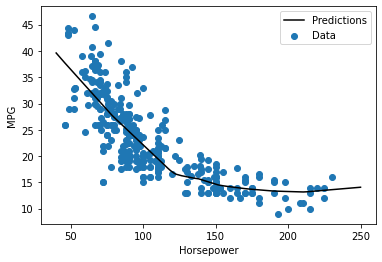

In [14]:
x = tf.linspace(40, 250, 251)
y = dnn_horsepower_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)